In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import functools
import itertools
import random
from pathlib import Path

import IPython.display as ipd
import matplotlib
import matplotlib.pyplot as plt
import ppgs
import torch
import torchaudio

import promonet

/home/mrm5248/micromamba/envs/promonet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Configuration name
ppgs.CONFIG = 'w2v2fb'

# Network width
ppgs.HIDDEN_CHANNELS = 512

# Dimensionality of input representation
ppgs.INPUT_CHANNELS = 768

# Number of hidden layers
ppgs.NUM_HIDDEN_LAYERS = 5

# Input representation
ppgs.REPRESENTATION = 'w2v2fb'

# Local checkpoint to use
# If None, Huggingface will be used unless a checkpoint is given in the CLI
ppgs.LOCAL_CHECKPOINT = f'/repos/ppgs/runs/w2v2fb/00200000.pt'

In [3]:
# Configuration name
ppgs.CONFIG = 'mel'

# Network width
ppgs.HIDDEN_CHANNELS = 256

# Dimensionality of input representation
ppgs.INPUT_CHANNELS = 80

# Number of hidden layers
ppgs.NUM_HIDDEN_LAYERS = 5

# Best representation
ppgs.BEST_REPRESENTATION = None

# Input representation
ppgs.REPRESENTATION = 'mel'

# Local checkpoint to use
# If None, Huggingface will be used unless a checkpoint is given in the CLI
ppgs.LOCAL_CHECKPOINT = f'/repos/ppgs/runs/mel/00200000.pt'

In [ ]:
# promonet.AUGMENT_LOUDNESS = False

# # Global input channels
# promonet.GLOBAL_CHANNELS = (
#     promonet.SPEAKER_CHANNELS +
#     promonet.AUGMENT_PITCH +
#     promonet.AUGMENT_LOUDNESS)

In [4]:
dataset = 'vctk'

# Get test stems
partition = promonet.load.partition(dataset)
if dataset == 'vctk':
    stems = partition['test']
elif dataset == 'daps':
    stems = list(itertools.chain(
        *[partition[key] for key in partition.keys()
          if key.startswith('test-adapt-')]))

In [5]:
# stem = random.choice(stems)
# while not stem.startswith('0032'):
#     stem = random.choice(stems)
stem = '0047/000757'
print(stem)
speakers = list(set(stem.split('/')[0] for stem in stems))
averages = promonet.load.per_speaker_averages()
speaker = stem.split('/')[0]
if dataset == 'vctk':
    checkpoint = promonet.RUNS_DIR / 'promonet' / 'generator-00400000.pt'
elif dataset == 'daps':
    checkpoint = (
        promonet.RUNS_DIR /
        'promonet' /
        'adapt' /
        dataset /
        speaker /
        'generator-00410000.pt')
text = promonet.load.text(promonet.CACHE_DIR / dataset / f'{stem}.txt')
audio = promonet.load.audio(promonet.CACHE_DIR / dataset / f'{stem}-100.wav')
print(text)
ipd.Audio(audio, rate=promonet.SAMPLE_RATE)

0047/000757
Both of those promises have already been honoured.



In [ ]:
promonet.convert.samples_to_seconds(audio.shape[-1])

In [ ]:
tag = None

### ProMoNet editing pipeline

In [6]:
def edit(
    prefix,
    audio,
    speaker,
    target_speaker=None,
    edit_kwargs=None,
    synthesize_kwargs=None,
    save_figure=True,
    save_original=True,
    method='promonet',
    highlight=None
):
    """Edit speech and plot the results"""
    if edit_kwargs is None:
        edit_kwargs = {}
    if synthesize_kwargs  is None:
        synthesize_kwargs = {}

    # Preprocess
    loudness, pitch, periodicity, ppg = promonet.preprocess.from_audio(
        audio,
        features=['ppg', 'pitch', 'periodicity', 'loudness'],
        gpu=0)

    # Edit
    (
        edited_loudness,
        edited_pitch,
        edited_periodicity,
        edited_ppg,
        grid
    ) = promonet.edit.from_features(
        loudness,
        pitch,
        periodicity,
        ppg,
        return_grid=True,
        **edit_kwargs)

    # Synthesize
    if method == 'world':
        synthesis_fn = functools.partial(
            promonet.baseline.world.from_audio,
            pitch=edited_pitch.cpu(),
            periodicity=edited_periodicity.cpu())
        edited = synthesis_fn(
            audio.cpu(),
            promonet.SAMPLE_RATE,
            grid=grid.cpu())
    elif method == 'promonet':
        edited = promonet.synthesize.from_features(
            edited_loudness,
            edited_pitch,
            edited_periodicity,
            edited_ppg,
            speaker=int(speaker),
            checkpoint=checkpoint,
            gpu=0,
            **synthesize_kwargs)

    # Plot and save results
    plot(
        prefix,
        audio,
        edited,
        edited_loudness,
        edited_pitch,
        edited_periodicity,
        edited_ppg,
        save_figure,
        save_original,
        highlight)


def plot(
    prefix,
    audio,
    edited,
    edited_loudness,
    edited_pitch,
    edited_periodicity,
    edited_ppg,
    save_figure=True,
    save_original=True,
    highlight=None
):
    """Plot overlay of features from input and synthesized audio"""
    # Preprocess synthesized audio
    (
        predicted_loudness,
        predicted_pitch,
        predicted_periodicity,
        predicted_ppg
    ) = promonet.preprocess.from_audio(
        edited,
        features=['ppg', 'pitch', 'periodicity', 'loudness'],
        gpu=0)

    # Make audio player
    ipd.display(ipd.Audio(audio.cpu(), rate=promonet.SAMPLE_RATE))
    ipd.display(ipd.Audio(edited.cpu(), rate=promonet.SAMPLE_RATE))

    # Make plot
    figure = promonet.plot.from_features(
        audio,
        promonet.preprocess.loudness.band_average(edited_loudness, 1),
        edited_pitch,
        edited_periodicity,
        edited_ppg,
        promonet.preprocess.loudness.band_average(predicted_loudness, 1),
        predicted_pitch,
        predicted_periodicity,
        predicted_ppg,
        features=['ppg', 'pitch', 'periodicity', 'loudness'],
        highlight=highlight)

    # Save
    prefix = Path(prefix)
    prefix.parent.mkdir(exist_ok=True, parents=True)
    if save_original:
        original = prefix.parent / 'Original' / prefix.name
        original.parent.mkdir(exist_ok=True, parents=True)
        torchaudio.save(f'{original}.wav', audio.cpu(), promonet.SAMPLE_RATE)
    if save_figure:
        figure.savefig(
            prefix.parent / f'{prefix.name}.png',
            bbox_inches='tight',
            pad_inches=0,
            transparent=True)
        figure.savefig(
            prefix.parent / f'{prefix.name}.pdf',
            bbox_inches='tight',
            pad_inches=0)
    torchaudio.save(f'{prefix}.wav', edited.cpu(), promonet.SAMPLE_RATE)

### Original

In [ ]:
loudness, pitch, periodicity, ppg = promonet.preprocess.from_audio(
    audio,
    features=['ppg', 'pitch', 'periodicity', 'loudness'],
    gpu=0)
figure = promonet.plot.from_features(
    audio,
    promonet.preprocess.loudness.band_average(loudness, 1),
    pitch,
    periodicity,
    ppg,
    features=['ppg', 'pitch', 'periodicity', 'loudness'])
# figure.savefig(f'original.png', bbox_inches='tight', pad_inches=0, transparent=True)

### Reconstruction

In [ ]:
file = (
    promonet.EVAL_DIR /
    'subjective' /
    'mels-ours' /
    f'vctk-{stem.replace("/", "-")}-original-100.wav')
mel_audio = promonet.load.audio(file)
loudness, pitch, periodicity, ppg = promonet.preprocess.from_audio(
    audio,
    features=['ppg', 'pitch', 'periodicity', 'loudness'],
    gpu=0)
plot(
    f'reconstruction/Mels/{tag}',
    audio,
    mel_audio,
    loudness,
    pitch,
    periodicity,
    ppg,
    save_figure=False)

In [ ]:
edit(
    # f'{"reconstruction" if dataset == "vctk" else "adaptation"}/Proposed/{tag}',
    'thesis/reconstruction',
    audio,
    speaker if dataset == 'vctk' else 0)

In [ ]:
# Preprocess
loudness, pitch, periodicity, ppg = promonet.preprocess.from_audio(
    audio,
    features=['ppg', 'pitch', 'periodicity', 'loudness'],
    gpu=0)

# Synthesize
edited = promonet.synthesize.from_features(
    loudness,
    pitch,
    periodicity,
    ppg,
    speaker=int(speaker),
    checkpoint=checkpoint,
    gpu=0)

# Preprocess synthesized audio
(
    predicted_loudness,
    predicted_pitch,
    predicted_periodicity,
    predicted_ppg
) = promonet.preprocess.from_audio(
    edited,
    features=['ppg', 'pitch', 'periodicity', 'loudness'],
    gpu=0)

# Make audio player
ipd.display(ipd.Audio(audio.cpu(), rate=promonet.SAMPLE_RATE))
ipd.display(ipd.Audio(edited.cpu(), rate=promonet.SAMPLE_RATE))

# Save original plot
figure = promonet.plot.from_features(
    audio,
    promonet.preprocess.loudness.band_average(loudness, 1),
    pitch,
    periodicity,
    ppg,
    features=['ppg', 'pitch', 'periodicity', 'loudness'])
prefix = Path('thesis/reconstruction')
prefix.mkdir(exist_ok=True, parents=True)
torchaudio.save(prefix / 'original.wav', audio.cpu(), promonet.SAMPLE_RATE)
figure.savefig(
    prefix / 'original.png',
    bbox_inches='tight',
    pad_inches=0,
    transparent=True)
figure.savefig(
    prefix / 'original.pdf',
    bbox_inches='tight',
    pad_inches=0)

# Save reconstruction plot
figure = promonet.plot.from_features(
    edited,
    promonet.preprocess.loudness.band_average(predicted_loudness, 1),
    predicted_pitch,
    predicted_periodicity,
    predicted_ppg,
    features=['ppg', 'pitch', 'periodicity', 'loudness'])
prefix = Path('thesis/reconstruction')
prefix.mkdir(exist_ok=True, parents=True)
torchaudio.save(prefix / 'reconstructed.wav', audio.cpu(), promonet.SAMPLE_RATE)
figure.savefig(
    prefix / 'reconstructed.png',
    bbox_inches='tight',
    pad_inches=0,
    transparent=True)
figure.savefig(
    prefix / 'reconstructed.pdf',
    bbox_inches='tight',
    pad_inches=0)

In [ ]:
figure, axis = plt.subplots(1, 1, figsize=(9, 2.25))
axis.plot(edited.squeeze().cpu(), color='black', linewidth=.5)
axis.set_xmargin(0.)
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.spines['bottom'].set_visible(False)
axis.spines['left'].set_visible(False)
axis.set_xticks([])
axis.set_yticks([])
axis.set_ylim([-1., 1.])
axis.tick_params(axis=u'both', which=u'both', length=0)
figure.savefig('thesis/reconstruction/reconstructed-audio.png', bbox_inches='tight', pad_inches=0, transparent=True)
# for tick in [-1., 1.]:
#     axis.hlines(tick, xmin=0., xmax=audio.shape[-1], color='#aaaa', linestyle='--')


### Pitch shifting

In [ ]:
edit(f'thesis/Proposed (+600¢)', audio, speaker, highlight='pitch', edit_kwargs={'pitch_shift_cents': 600.})
edit(f'thesis/Proposed (-600¢)', audio, speaker, highlight='pitch', edit_kwargs={'pitch_shift_cents': -600.})
# edit(f'pitch-shifting/WORLD (+600¢)/{tag}', audio, speaker, save_figure=False, edit_kwargs={'pitch_shift_cents': 600.}, method='world')
# edit(f'pitch-shifting/WORLD (-600¢)/{tag}', audio, speaker, save_figure=False, edit_kwargs={'pitch_shift_cents': -600.}, me|thod='world')

In [ ]:
edit(f'pitch-range/_/-1200¢', audio, speaker, save_original=False, save_figure=False, edit_kwargs={'pitch_shift_cents': -1200.})
edit(f'pitch-range/_/-600¢', audio, speaker, save_original=False, save_figure=False, edit_kwargs={'pitch_shift_cents': -600.})
torchaudio.save(f'pitch-range/_/Original.wav', audio, promonet.SAMPLE_RATE)
edit(f'pitch-range/_/+600¢', audio, speaker, save_original=False, save_figure=False, edit_kwargs={'pitch_shift_cents': 600.})
edit(f'pitch-range/_/+1200¢', audio, speaker, save_original=False, save_figure=False, edit_kwargs={'pitch_shift_cents': 1200.})

In [ ]:
original_audio = promonet.load.audio('pitch-range/_/Original.wav')
original_pitch, original_periodicity = promonet.preprocess.from_audio(
    original_audio,
    features=['pitch', 'periodicity'],
    gpu=0)
original_pitch = original_pitch.cpu().squeeze()
original_periodicity = original_periodicity.cpu().squeeze()
voiced = original_periodicity > promonet.VOICING_THRESHOLD
original_pitch[~voiced] = float('nan')
time = torch.linspace(0, len(original_pitch) * (promonet.HOPSIZE / promonet.SAMPLE_RATE), len(original_pitch))
plt.figure(figsize=(12, 6))
plt.plot(time, original_pitch, label='Original', color='black')
for spine in plt.gca().spines.values():
    spine.set_visible(False)

colors = ['blue', 'orange', 'red', 'green']
for color, file in zip(colors, Path('pitch-range/_/').glob('*¢.wav')):
    cents = float(file.stem[:-1])
    ratio = promonet.convert.cents_to_ratio(cents)
    x = promonet.load.audio(file)
    y = promonet.preprocess.from_audio(
        x,
        features=['pitch'],
        gpu=0)[0].cpu().squeeze()
    plt.plot(time, original_pitch * ratio, label=file.stem, color=color)
    y[~voiced] = float('nan')
    plt.plot(time, y, color=color, linestyle='--')
plt.yscale('symlog')
plt.yticks([50, 100, 200], ['50', '100', '200'])
plt.ylim(40., 350.)
plt.xlim(0, 11)
handles, labels = plt.gca().get_legend_handles_labels()
order = [4, 3, 0, 2, 1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False, fontsize=12)
plt.xlabel('Time (seconds)', fontsize=16)
plt.ylabel('Pitch (Hz)', fontsize=16)

for tick in plt.yticks()[0]:
    plt.hlines(tick, 0, time[-1], color='gray', linestyle='dotted', alpha=.25)

plt.savefig('pitch-range/pitch-range.png', bbox_inches='tight', pad_inches=0.1)

### Time-stretching

In [ ]:
edit(f'thesis/Proposed (1.41x)', audio, speaker, highlight='duration', edit_kwargs={'time_stretch_ratio': 1.41})
edit(f'thesis/Proposed (0.71x)', audio, speaker, highlight='duration', edit_kwargs={'time_stretch_ratio': 0.71})
# edit(f'time-stretching/WORLD (1.41x)/{tag}', audio, speaker, save_figure=False, edit_kwargs={'time_stretch_ratio': 1.41}, method='world')
# edit(f'time-stretching/WORLD (0.71x)/{tag}', audio, speaker, save_figure=False, edit_kwargs={'time_stretch_ratio': 0.71}, method='world')

In [ ]:
edit(f'time-range/_/0.50x', audio, speaker, save_original=False, save_figure=False, edit_kwargs={'time_stretch_ratio': 0.50})
edit(f'time-range/_/0.71x', audio, speaker, save_original=False, save_figure=False, edit_kwargs={'time_stretch_ratio': 0.71})
torchaudio.save(f'time-range/_/Original.wav', audio, promonet.SAMPLE_RATE)
edit(f'time-range/_/1.41x', audio, speaker, save_original=False, save_figure=False, edit_kwargs={'time_stretch_ratio': 1.41})
edit(f'time-range/_/2.00x', audio, speaker, save_original=False, save_figure=False, edit_kwargs={'time_stretch_ratio': 2.00})

### Perceptual loudness

In [ ]:
stem_map = {
    'Male 1': '0016/000342',
    'Male 2': '0047/000540',
    'Female 1': '0082/000402',
    'Female 2': '0013/000022'
}
for tag, stem in stem_map.items():
    speaker = stem.split('/')[0]
    text = promonet.load.text(promonet.CACHE_DIR / dataset / f'{stem}.txt')
    audio = promonet.load.audio(promonet.CACHE_DIR / dataset / f'{stem}-100.wav')
    print(text)
    ipd.display(ipd.Audio(audio, rate=promonet.SAMPLE_RATE))
    edit_fn = functools.partial(
        edit,
        audio=audio,
        speaker=speaker,
        save_figure=False)
    edit_fn(f'loudness/No augment (-10 dBA)/{tag}', edit_kwargs={'loudness_scale_db': -10.})
    edit_fn(f'loudness/No augment (+10 dBA)/{tag}', edit_kwargs={'loudness_scale_db': 10.})

In [ ]:
edit_fn = functools.partial(
    edit,
    audio=audio,
    speaker=speaker)

In [ ]:
edit_fn(f'thesis/Proposed (reconstruction)')
edit_fn(f'thesis/Proposed (-10 dBA)', highlight='loudness', edit_kwargs={'loudness_scale_db': -10.})
edit_fn(f'thesis/Proposed (+10 dBA)', highlight='loudness', edit_kwargs={'loudness_scale_db': 10.})
# edit_fn(f'thesis/r_l = 2.0/{tag}', synthesize_kwargs={'loudness_ratio': 2.0})
# edit_fn(f'thesis/r_l = 0.5/{tag}', synthesize_kwargs={'loudness_ratio': 0.5})

In [ ]:
original = promonet.load.audio('thesis/Original/Proposed (-10 dBA).wav')
reconstructed = promonet.load.audio('thesis/Proposed (reconstruction).wav')
quiet = promonet.load.audio('thesis/Proposed (-10 dBA).wav')
loud = promonet.load.audio('thesis/Proposed (+10 dBA).wav')

def spectra(x, volume_match_with=None):
    if volume_match_with is not None:
        loudness = promonet.preprocess.loudness.from_audio(x)
        original_loudness = promonet.preprocess.loudness.from_audio(volume_match_with)
        gain = original_loudness - loudness
        x = promonet.preprocess.loudness.limit(promonet.preprocess.loudness.shift(x, gain))
    spectrogram = promonet.preprocess.spectrogram.from_audio(x)
    return spectrogram.squeeze().mean(dim=-1)[1:]

plt.figure(figsize=(12, 4))
frequencies = torch.abs(torch.fft.fftfreq(
    promonet.NUM_FFT,
    1 / promonet.SAMPLE_RATE
)[1:promonet.NUM_FFT // 2 + 1])
# plt.plot(frequencies[1:], spectra(original)[1:], label='Original', linewidth=2)
plt.plot(frequencies[1:], spectra(reconstructed, original)[1:], label='Reconstruction', linewidth=2)
plt.plot(frequencies[1:], spectra(quiet, original)[1:], label='−10 dBA', linewidth=2)
plt.plot(frequencies[1:], spectra(loud, original)[1:], label='+10 dBA', linewidth=2)
plt.xlabel('Frequency (Hz)', fontsize=14)
plt.ylabel('Energy (dB)', fontsize=14)
plt.ylim(0, 5)
xticks = [50, 100, 200, 400, 800, 1600, 3200, 6400]
plt.xscale('symlog')
plt.xticks(xticks, [str(tick) for tick in xticks], fontsize=14)
plt.yticks(*plt.yticks(), fontsize=14)
plt.xlim(promonet.FMIN * .9, promonet.SAMPLE_RATE // 2)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
for tick in plt.yticks()[0]:
    plt.hlines(tick, xmin=1.1 * frequencies[1], xmax=frequencies[-1], color='#aaaa', linestyle='--')
plt.tick_params(
    axis='y',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False,
    pad=0,
    length=0)
plt.legend(frameon=False, fontsize=12)
plt.savefig('spectra.pdf', bbox_inches='tight', pad_inches=.1)
plt.savefig('spectra.png', bbox_inches='tight', pad_inches=.1, transparent=True)

In [ ]:
edit_fn(f'loudness-range/_/-10dBA', save_original=False, edit_kwargs={'loudness_scale_db': -10.})
edit_fn(f'loudness-range/_/-5dBA', save_original=False, edit_kwargs={'loudness_scale_db': -5.})
torchaudio.save(f'loudness-range/_/Original.wav', audio, promonet.SAMPLE_RATE)
edit_fn(f'loudness-range/_/+5dBA', save_original=False, edit_kwargs={'loudness_scale_db': 5.})
edit_fn(f'loudness-range/_/+10dBA', save_original=False, edit_kwargs={'loudness_scale_db': 10.})

In [ ]:
original_audio = promonet.load.audio('loudness-range/_/Original.wav')
original_loudness = promonet.preprocess.from_audio(
    original_audio,
    features=['loudness'],
    gpu=0,
    loudness_bands=1)[0]
original_loudness = original_loudness.cpu().squeeze()
time = torch.linspace(0, len(original_loudness) * (promonet.HOPSIZE / promonet.SAMPLE_RATE), len(original_loudness))
plt.figure(figsize=(12, 6))
plt.plot(time, original_loudness, label='Original', color='black')
for spine in plt.gca().spines.values():
    spine.set_visible(False)

colors = ['blue', 'orange', 'red', 'green']
for color, file in zip(colors, Path('loudness-range/_/').glob('*dBA.wav')):
    decibels = float(file.stem[:-3])
    x = promonet.load.audio(file)
    y = promonet.preprocess.from_audio(
        x,
        features=['loudness'],
        gpu=0,
        loudness_bands=1)[0].cpu().squeeze()
    plt.plot(time, original_loudness + decibels, label=file.stem, color=color)
    plt.plot(time, y, color=color, linestyle='--')
# plt.yscale('symlog')
# plt.yticks([50, 100, 200], ['50', '100', '200'])
# plt.ylim(40., 350.)
# plt.xlim(0, 11)
handles, labels = plt.gca().get_legend_handles_labels()
order = [4, 3, 0, 2, 1]
plt.legend([handles[idx] for idx   in order],[labels[idx] for idx in order], frameon=False, fontsize=12)
plt.xlabel('Time (seconds)', fontsize=16)
# plt.legend()
plt.ylabel('Loudness (dBA)', fontsize=16)

for tick in plt.yticks()[0]:
    plt.hlines(tick, 0, time[-1], color='gray', linestyle='dotted', alpha=.25)

plt.savefig('loudness-range/loudness-range.png', bbox_inches='tight', pad_inches=0.1)

### Voice conversion

In [15]:
# Select a random target speaker
target_speaker = speaker
# target_speaker == '0032'
while target_speaker == speaker:
    target_speaker = random.choice(speakers)
mean_difference_cents = promonet.convert.ratio_to_cents(averages[target_speaker] / averages[speaker])
print(averages[speaker], averages[target_speaker], mean_difference_cents)
target_sample_stem = random.choice(
    [stem for stem in stems if stem.startswith(target_speaker)])
# target_sample_stem = '0032/000734'
target_sample = promonet.load.audio(
    promonet.CACHE_DIR /
    'vctk' /
    f'{target_sample_stem}-100.wav')
ipd.display(ipd.Audio(target_sample.cpu(), rate=promonet.SAMPLE_RATE))
print(target_sample_stem)

99.11680231904514 112.94078250308847 226.03797912597645


0032/000780


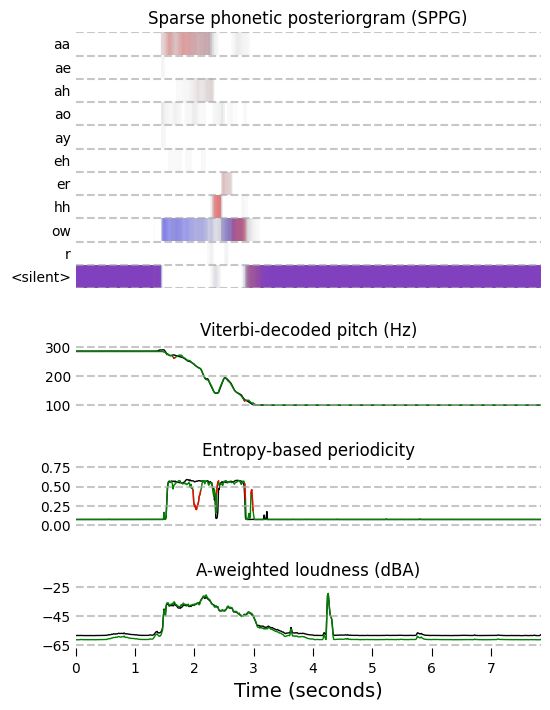

In [17]:
audio = promonet.load.audio('../yawn.wav')

edit(
    'thesis/yawn',
    audio,
    target_speaker,
    # edit_kwargs={'pitch_shift_cents': mean_difference_cents},
    save_original=True)

In [ ]:
# Edit speaker
# target_directory = Path('thesis/Target')
# source_directory = Path('thesis/Source')
# target_directory.mkdir(exist_ok=True, parents=True)
# source_directory.mkdir(exist_ok=True, parents=True)
torchaudio.save('thesis/target.wav', target_sample, promonet.SAMPLE_RATE)
torchaudio.save('thesis/source.wav', audio, promonet.SAMPLE_RATE)
edit(
    'thesis/proposed',
    audio,
    target_speaker,
    edit_kwargs={'pitch_shift_cents': mean_difference_cents},
    save_original=False)

### Formant editing

In [ ]:
edit(f'thesis/Proposed (r_f = 1.41)', audio, speaker, highlight='ppg', synthesize_kwargs={'formant_ratio': 1.41})
edit(f'thesis/Proposed (r_f = 0.71)', audio, speaker, highlight='ppg', synthesize_kwargs={'formant_ratio': 0.71})

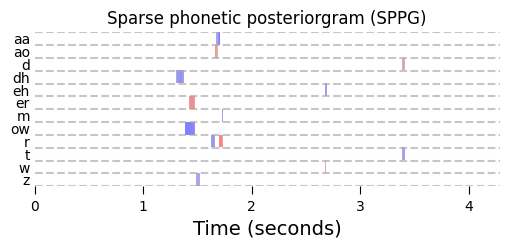

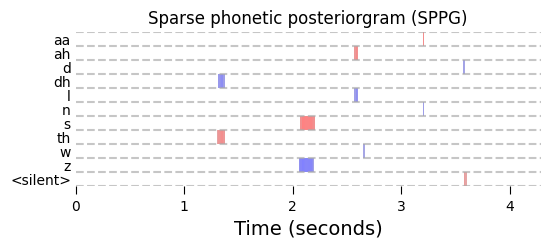

In [32]:
# figure, axes = plt.subplots(
#     1,
#     1,
#     figsize=(6, 2))

# Formant pronunciation breakout figure
down = promonet.load.audio('thesis/Proposed (r_f = 0.71).wav')
up = promonet.load.audio('thesis/Proposed (r_f = 1.41).wav')

# Get PPGs
loudness, pitch, periodicity, ppg = promonet.preprocess.from_audio(
    audio,
    features=['ppg', 'pitch', 'periodicity', 'loudness'],
    gpu=0)
ppg_down = promonet.preprocess.from_audio(down, features=['ppg'], gpu=0)[0]
ppg_up = promonet.preprocess.from_audio(up, features=['ppg'], gpu=0)[0]

# Compute differences
threshold = .35
delta_down = (ppg - ppg_down)
delta_down_inverse = -delta_down
delta_down[delta_down < 0.] = 0.
delta_down_inverse[delta_down_inverse < 0.] = 0.
mask = torch.logical_and(delta_down < (1 - threshold), delta_down_inverse < (1 - threshold))
delta_down[mask] = 0.
delta_down_inverse[mask] = 0.

delta_up = (ppg - ppg_up)
delta_up_inverse = -delta_up
delta_up[delta_up < 0.] = 0.
delta_up_inverse[delta_up_inverse < 0.] = 0.
mask = torch.logical_and(delta_up < (1 - threshold), delta_up_inverse < (1 - threshold))
delta_up[mask] = 0.
delta_up_inverse[mask] = 0.

# Make plot
figure = promonet.plot.from_features(
    audio,
    promonet.preprocess.loudness.band_average(loudness, 1),
    pitch,
    periodicity,
    delta_down,
    promonet.preprocess.loudness.band_average(loudness, 1),
    pitch,
    periodicity,
    delta_down_inverse,
    features=['ppg'],
    ppg_threshold=1 - threshold)
figure.savefig('thesis/formant-breakout-down.pdf', bbox_inches='tight', pad_inches=0)
figure.savefig('thesis/formant-breakout-down.png', bbox_inches='tight', pad_inches=0, transparent=True)

figure = promonet.plot.from_features(
    audio,
    promonet.preprocess.loudness.band_average(loudness, 1),
    pitch,
    periodicity,
    delta_up,
    promonet.preprocess.loudness.band_average(loudness, 1),
    pitch,
    periodicity,
    delta_up_inverse,
    features=['ppg'],
    ppg_threshold=1 - threshold)
figure.savefig('thesis/formant-breakout-up.pdf', bbox_inches='tight', pad_inches=0)
figure.savefig('thesis/formant-breakout-up.png', bbox_inches='tight', pad_inches=0, transparent=True)

In [ ]:
plt.plot(ppg_down.squeeze()[ppgs.PHONEMES.index('th')].cpu())
plt.plot(ppg.squeeze()[ppgs.PHONEMES.index('dh')].cpu())

In [ ]:
delta_down.shape

In [ ]:
plt.imshow(delta_down.cpu())

In [ ]:
edit(f'formant-range/_/r_f = 0.50', audio, speaker, save_original=False, save_figure=False, synthesize_kwargs={'formant_ratio': 0.51})
edit(f'formant-range/_/r_f = 0.71', audio, speaker, save_original=False, save_figure=False, synthesize_kwargs={'formant_ratio': 0.71})
torchaudio.save(f'formant-range/_/Original.wav', audio, promonet.SAMPLE_RATE)
edit(f'formant-range/_/r_f = 1.41', audio, speaker, save_original=False, save_figure=False, synthesize_kwargs={'formant_ratio': 1.41})
edit(f'formant-range/_/r_f = 2.00', audio, speaker, save_original=False, save_figure=False, synthesize_kwargs={'formant_ratio': 1.99})

### Accent editing

In [ ]:
# Load
# audio = promonet.load.audio('/hemera-storage1/pardo/max/test-audio/ill-be-back-denoise.wav')

# Preprocess
loudness, pitch, periodicity, ppg = promonet.preprocess.from_audio(
    audio,
    features=['ppg', 'pitch', 'periodicity', 'loudness'],
    gpu=0)
# log_mean_f0 = torch.log2(pitch[periodicity > promonet.VOICING_THRESHOLD]).mean()
# mean_difference_cents = promonet.convert.ratio_to_cents(2 ** log_mean_f0 / averages[speaker])
# print(mean_difference_cents)
# pitch = pitch * promonet.convert.cents_to_ratio(-mean_difference_cents + 2)
# pitch = torch.clip(pitch, promonet.FMIN, promonet.FMAX)

# Edit
edited_ppg = ppg.clone()
# edited_ppg = ppgs.edit.regex(edited_ppg[0].cpu(), ['b', 'aa'], ['b', 'aw'])[None].to('cuda:0')
# edited_ppg = ppgs.edit.reallocate(edited_ppg[0], 'ay', 'aw')[None]
# edited_ppg = ppgs.edit.reallocate(edited_ppg[0], 'aa', 'ah', )[None]
# edited_ppg = ppgs.edit.reallocate(edited_ppg[0], 'ae', 'ah', )[None]
# edited_ppg = ppgs.edit.reallocate(edited_ppg[0], 'eh', 'ah', )[None]
# edited_ppg = ppgs.edit.reallocate(edited_ppg[0], 'ih', 'ah', )[None]
# edited_ppg = ppgs.edit.reallocate(edited_ppg[0], 'ay', 'ao')[None]
edited_ppg = ppgs.edit.regex(ppg[0].cpu(), ['dh', 'ah'], ['th', 'ah'], reallocate=True)[None].to('cuda:0')
edited_ppg = ppgs.edit.regex(edited_ppg[0].cpu(), ['n', 'aa', 't'], ['n', 'ah', 't'], reallocate=True)[None].to('cuda:0')
edited_ppg = ppgs.edit.reallocate(edited_ppg[0], 'er', 'r')[None]
edited_ppg = ppgs.edit.reallocate(edited_ppg[0], 'ae', 'ih')[None]


# print([p for i, p in enumerate(ppgs.PHONEMES) if ppg[0, i].max() > 1e-6])
# edited_ppg = ppgs.edit.reallocate(ppg[0], 's', 'sh')[None]
# edited_ppg = ppgs.edit.shift(ppg[0], 'eh', .2)[None]
# edited_ppg = ppgs.edit.regex(ppg[0].cpu(), ['hh', 'ae'], ['hh', 'aa'])[None].to('cuda:0')
# edited_ppg = ppgs.edit.regex(ppg[0].cpu(), ['uw'], ['aa'])[None].to('cuda:0')
# edited_ppg = ppgs.edit.regex(edited_ppg[0].cpu(), ['ah'], ['uh'])[None].to('cuda:0')
# edited_ppg = ppgs.edit.reallocate(edited_ppg[0].cpu(), 'dh', 'th')[None].to('cuda:0')
# edited_ppg = ppgs.edit.regex(ppg[0].cpu(), ['dh', 'ah'], ['th', 'ah'], reallocate=True)[None].to('cuda:0')
# edited_ppg = ppgs.edit.regex(edited_ppg[0].cpu(), ['n', 'aa', 't'], ['n', 'ah', 't'], reallocate=True)[None].to('cuda:0')
# edited_ppg = ppgs.edit.reallocate(edited_ppg[0], 'er', 'r')[None]
# edited_ppg = ppgs.edit.reallocate(edited_ppg[0], 'ae', 'ih')[None]
# edited_ppg = ppg

# Synthesize
edited = promonet.synthesize.from_features(
    loudness,
    pitch,
    periodicity,
    edited_ppg,
    speaker=int(speaker),
    checkpoint=checkpoint,
    gpu=0)

# Plot and save results
plot(
    'thesis/accent',
    audio,
    edited,
    promonet.preprocess.loudness.band_average(loudness, 1),
    pitch,
    periodicity,
    edited_ppg,
    highlight='ppg')

### Automatic onomatopoeia

In [ ]:
# Load
audio = promonet.load.audio('/hemera-storage1/pardo/max/test-audio/cat.wav').mean(0, keepdim=True)

# Preprocess
loudness, pitch, periodicity, ppg = promonet.preprocess.from_audio(
    audio,
    features=['ppg', 'pitch', 'periodicity', 'loudness'],
    gpu=0)
log_mean_f0 = torch.log2(pitch[periodicity > promonet.VOICING_THRESHOLD]).mean()
mean_difference_cents = promonet.convert.ratio_to_cents(2 ** log_mean_f0 / averages[speaker])
print(mean_difference_cents)
pitch = pitch * promonet.convert.cents_to_ratio(-mean_difference_cents)
pitch = torch.clip(pitch, promonet.FMIN, promonet.FMAX)

# Synthesize
print(
    loudness.shape,
    pitch.shape,
    periodicity.shape,
    loudness.shape,
)
edited = promonet.synthesize.from_features(
    loudness,
    pitch,
    periodicity,
    ppg,
    speaker=int(speaker),
    checkpoint=checkpoint,
    gpu=0)

# Plot and save results
plot(
    'thesis/onomatopoeia',
    audio,
    edited,
    promonet.preprocess.loudness.band_average(loudness, 1),
    pitch,
    periodicity,
    ppg)

In [ ]:
2 ** log_mean_f0 / averages[speaker]

In [ ]:
ppg_down